In [6]:
%matplotlib inline
import os
from scipy.spatial import distance
from tqdm import tqdm as tqdm
import pandas as pd
os.chdir('/vco260/')
from src.gene_collaborative_filtering import *
from src.model_helper import *

In [7]:
total=pd.read_parquet('data/stage_2_full_data.parquet')
total.drop(columns=['mim_categorical'],inplace=True)

In [8]:
total.drop_duplicates(subset='Gene names_categorical',inplace=True)

In [9]:
def save_mode_(model,address):
    '''adress includes the path
    saves a model in adress.json +adress.h5
    to be loaded using load_model_'''
    # serialize model to JSON
    model_json = model.to_json()
    with open(address+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(address+".h5")
    print("Saved model to disk")
 
def load_model_(json_address,h5_address): 
    '''
    use by supplying address without extensions
    load_model_(file_address)
    while there exist file_address.h5 and file_address.json
    '''
    # load json and create model
    json_file = open(json_address, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(h5_address)
    print("Loaded model from disk")
    return loaded_model

def train_stage2_collab_filt_grid(df,
                            epochs=1,
                            patience = 50,
                            batch_size=np.power(2,10),
                            steps=100,
                            minimum_lr=0.0001,
                            maximum_lr=0.003):
    train=df.sample(frac=0.98)
    test=df.loc[~df.index.isin(train.index)]
    model=get_model(df)
    #validation data sample and generator
    run_name='batch_size='+str(batch_size)+'minimum_lr='+str(minimum_lr)+'maximum_lr='+str(maximum_lr)
    #hyperparamters
    epoch_size = train.shape[0] #number of training examples per epoch. should be larger
     #stop training if the loss not getting lower..
    #     step_size = int(0.5 * steps_per_epoch*epochs) #2 steps in cycle
    lr_callback = LRFinder(epoch_size, batch_size,
                           minimum_lr, maximum_lr,
                           lr_scale='exp', save_dir='models/')    

    run_num = 'amit_train_' + time.strftime('%Y_%m_%d_%H_%M')

    #callbacks
    checkpoint = ModelCheckpoint('models/' + run_name + '.h5', save_best_only=True, monitor='loss', save_weights_only=True)
    logger = CSVLogger('models/' + run_num + '_log.csv')
    estop = EarlyStopping(monitor='loss', patience = patience)
    #     clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, step_size=step_size)
    callbacks = [checkpoint, logger, estop,lr_callback]
    model.fit(x=gene_data_prep(train),y=train[np.arange(300).astype(str)].values,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(gene_data_prep(test),test[np.arange(300).astype(str)].values),
             callbacks=callbacks)
    save_to_pickle((lr_callback),"models/hist"+run_name+".pickle")
    
    
def train_stage2_collab_filt(df,
                            epochs=1,
                            patience = 50,
                            batch_size=np.power(2,10),
                            steps=100,
                            minimum_lr=0.0001,
                            maximum_lr=0.003):
    train=df.sample(frac=0.98)
    test=df.loc[~df.index.isin(train.index)]
    model=get_model(df)
    #validation data sample and generator
    run_name='batch_size='+str(batch_size)+'minimum_lr='+str(minimum_lr)+'maximum_lr='+str(maximum_lr)
    #hyperparamters
    epoch_size = train.shape[0] #number of training examples per epoch. should be larger
     #stop training if the loss not getting lower..
    #     step_size = int(0.5 * steps_per_epoch*epochs) #2 steps in cycle
  

    run_num = 'amit_train_' + time.strftime('%Y_%m_%d_%H_%M')

    #callbacks
    checkpoint = ModelCheckpoint('models/' + run_name + '.h5', save_best_only=True, monitor='loss', save_weights_only=True)
    logger = CSVLogger('models/' + run_num + '_log.csv')
    estop = EarlyStopping(monitor='loss', patience = patience)
    clr = CyclicLR(base_lr=minimum_lr, max_lr=maximum_lr, step_size=batch_size)
    callbacks = [checkpoint, logger, estop,clr]
    model.fit(x=gene_data_prep(train),y=train[np.arange(300).astype(str)].values,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(gene_data_prep(test),test[np.arange(300).astype(str)].values),
             callbacks=callbacks)
    save_mode_(model,'models/stage_2_regression_2019_02_12')

In [ ]:
for i in [np.power(2,7),np.power(2,8),np.power(2,9)]:    
    for j in [(1/100000,1/1000),(1/1000,1/10),(1/10,10)]:
        print("bs"+str(i)+"lr"+str(j))
        train_stage2_collab_filt_grid(total,
                                 batch_size=i,
                                 minimum_lr=j[0],maximum_lr=j[1])

# run_num=0
# patience=200
# min_lr=0.0001
# max_lr=0.003
# step_size=
# model=get_model(total)
# #callbacks
# checkpoint = ModelCheckpoint('../models/' + str(run_num) + '_GO_TERM_CLASSIFIER_take_4_best.h5', 
#                              save_best_only=True, monitor='loss', save_weights_only=True)
# logger = CSVLogger('../models/' + str(run_num) + '_GO_TERM_CLASSIFIER_take_4_log.csv')
# estop = EarlyStopping(monitor='loss', patience = patience)
# clr = CyclicLR(base_lr=min_lr, max_lr=max_lr, step_size=step_size)
# callbacks = [checkpoint, logger, estop, clr]

bs128lr(1e-05, 0.001)
Train on 101091 samples, validate on 2063 samples
Epoch 1/1
  9984/101091 [=>............................] - ETA: 1:40 - loss: 1.3054 - LRFinder: lr = 0.00001578 


 20096/101091 [====>.........................] - ETA: 1:14 - loss: 1.2991 - LRFinder: lr = 0.00002503 


 30208/101091 [=======>......................] - ETA: 1:01 - loss: 1.2989 - LRFinder: lr = 0.00003972 


 40448/101091 [===========>..................] - ETA: 50s - loss: 1.2926 - LRFinder: lr = 0.00006339 


 50688/101091 [==============>...............] - ETA: 41s - loss: 1.2866 - LRFinder: lr = 0.00010118 


 60928/101091 [=================>............] - ETA: 32s - loss: 1.2794 - LRFinder: lr = 0.00016148 


 71168/101091 [====================>.........] - ETA: 23s - loss: 1.2686 - LRFinder: lr = 0.00025773 


 81408/101091 [=======================>......] - ETA: 15s - loss: 1.2546 - LRFinder: lr = 0.00041135 


 91648/101091 [==========================>...] - ETA: 7s - loss: 1.2372 - LRFinder: lr = 0.00065654 


100992/101091 [============================>.] - ETA: 0s - loss: 1.2178 - LRFinder: lr = 0.00100586 
 - LRFinder: lr = 0.00101176 
101091/101091 [==============================] - 81s 796us/step - loss: 1.2175 - val_loss: 0.6913
	LR Finder : Saved the losses and learning rate values in path : {models/}
bs128lr(0.001, 0.1)
Train on 101091 samples, validate on 2063 samples
Epoch 1/1
   640/101091 [..............................] - ETA: 10:46 - loss: 1.3700 - LRFinder: lr = 0.00102965 


 10752/101091 [==>...........................] - ETA: 1:43 - loss: 1.2212 - LRFinder: lr = 0.00163380 


 20864/101091 [=====>........................] - ETA: 1:18 - loss: 1.1203 - LRFinder: lr = 0.00259242 


 30976/101091 [========>.....................] - ETA: 1:03 - loss: 1.0687 - LRFinder: lr = 0.00411352 


 41216/101091 [===========>..................] - ETA: 52s - loss: 1.0398 - LRFinder: lr = 0.00656537 


 51456/101091 [==============>...............] - ETA: 42s - loss: 1.0211 - LRFinder: lr = 0.01047863 


 61696/101091 [=================>............] - ETA: 33s - loss: 1.0085 - LRFinder: lr = 0.01672439 


 71936/101091 [====================>.........] - ETA: 24s - loss: 0.9974 - LRFinder: lr = 0.02669291 


 82176/101091 [=======================>......] - ETA: 15s - loss: 0.9892 - LRFinder: lr = 0.04260314 


 92416/101091 [==========================>...] - ETA: 7s - loss: 0.9809 - LRFinder: lr = 0.06799662 


100992/101091 [============================>.] - ETA: 0s - loss: 0.9738 - LRFinder: lr = 0.10058614 
 - LRFinder: lr = 0.10117570 
101091/101091 [==============================] - 84s 834us/step - loss: 0.9737 - val_loss: 0.6357
	LR Finder : Saved the losses and learning rate values in path : {models/}
bs128lr(0.1, 10)
Train on 101091 samples, validate on 2063 samples
Epoch 1/1
  1408/101091 [..............................] - ETA: 5:50 - loss: 0.9987 - LRFinder: lr = 0.10663967 


 11520/101091 [==>...........................] - ETA: 1:39 - loss: 0.9558 - LRFinder: lr = 0.16921016 


 21632/101091 [=====>........................] - ETA: 1:16 - loss: 0.9305 - LRFinder: lr = 0.26849365 


 31744/101091 [========>.....................] - ETA: 1:02 - loss: 0.8954 - LRFinder: lr = 0.42603170 


 41984/101091 [===========>..................] - ETA: 51s - loss: 0.8569 - LRFinder: lr = 0.67996699 


 52224/101091 [==============>...............] - ETA: 41s - loss: 0.8212 - LRFinder: lr = 1.08525952 


 62464/101091 [=================>............] - ETA: 32s - loss: 0.7991 - LRFinder: lr = 1.73212578 


 72704/101091 [====================>.........] - ETA: 23s - loss: 0.7814 - LRFinder: lr = 2.76455456 


 82944/101091 [=======================>......] - ETA: 14s - loss: 0.7697 - LRFinder: lr = 4.38664772 


 93056/101091 [==========================>...] - ETA: 6s - loss: 1.5848 - LRFinder: lr = 6.83952516 


100992/101091 [============================>.] - ETA: 0s - loss: 1.7397 - LRFinder: lr = 9.59917764 
 - LRFinder: lr = 9.65544039 
101091/101091 [==============================] - 83s 826us/step - loss: 1.7387 - val_loss: 1.4325
	LR Finder : Saved the losses and learning rate values in path : {models/}
bs256lr(1e-05, 0.001)
Train on 101091 samples, validate on 2063 samples
Epoch 1/1
  3584/101091 [>.............................] - ETA: 2:53 - loss: 1.3138 - LRFinder: lr = 0.00001178 


 23808/101091 [======>.......................] - ETA: 58s - loss: 1.3075 - LRFinder: lr = 0.00002974 


 44288/101091 [============>.................] - ETA: 36s - loss: 1.3050 - LRFinder: lr = 0.00007593 


 64768/101091 [==================>...........] - ETA: 22s - loss: 1.2976 - LRFinder: lr = 0.00019388 


 85248/101091 [========================>.....] - ETA: 9s - loss: 1.2809 - LRFinder: lr = 0.00049506 


100864/101091 [============================>.] - ETA: 0s - loss: 1.2597 - LRFinder: lr = 0.00101179 
 - LRFinder: lr = 0.00102371 
101091/101091 [==============================] - 62s 609us/step - loss: 1.2592 - val_loss: 0.7877
	LR Finder : Saved the losses and learning rate values in path : {models/}
bs256lr(0.001, 0.1)
Train on 101091 samples, validate on 2063 samples
Epoch 1/1
  4352/101091 [>.............................] - ETA: 2:30 - loss: 1.3058 - LRFinder: lr = 0.00122043 


 24576/101091 [======>.......................] - ETA: 54s - loss: 1.1410 - LRFinder: lr = 0.00307999 


 45056/101091 [============>.................] - ETA: 35s - loss: 1.0555 - LRFinder: lr = 0.00786456 


 65536/101091 [==================>...........] - ETA: 21s - loss: 1.0200 - LRFinder: lr = 0.02008163 


 86016/101091 [========================>.....] - ETA: 8s - loss: 0.9987 - LRFinder: lr = 0.05127712 


100864/101091 [============================>.] - ETA: 0s - loss: 0.9868 - LRFinder: lr = 0.10117869 
 - LRFinder: lr = 0.10237128 
101091/101091 [==============================] - 59s 586us/step - loss: 0.9867 - val_loss: 0.7028
	LR Finder : Saved the losses and learning rate values in path : {models/}
bs256lr(0.1, 10)
Train on 101091 samples, validate on 2063 samples
Epoch 1/1
  5120/101091 [>.............................] - ETA: 2:22 - loss: 0.9739 - LRFinder: lr = 0.12640993 


 25344/101091 [======>.......................] - ETA: 56s - loss: 0.9464 - LRFinder: lr = 0.31901918 


 45824/101091 [============>.................] - ETA: 38s - loss: 0.8950 - LRFinder: lr = 0.81459455 


 66304/101091 [==================>...........] - ETA: 23s - loss: 0.8415 - LRFinder: lr = 2.08001341 


 86528/101091 [========================>.....] - ETA: 9s - loss: 1.1174 - LRFinder: lr = 5.12771180 


100864/101091 [============================>.] - ETA: 0s - loss: 13.2926 - LRFinder: lr = 9.21247957 
 - LRFinder: lr = 9.32106630 
101091/101091 [==============================] - 69s 678us/step - loss: 13.2643 - val_loss: 0.6850


In [15]:
hists=['models/'+x for x in os.listdir('models/') if ('batch_size' in x and x.endswith('.pickle'))]
hists

['models/histbatch_size=64minimum_lr=0.001maximum_lr=0.1.pickle',
 'models/histbatch_size=32minimum_lr=0.1maximum_lr=10.pickle',
 'models/histbatch_size=64minimum_lr=0.1maximum_lr=10.pickle',
 'models/histbatch_size=16minimum_lr=0.001maximum_lr=0.1.pickle',
 'models/histbatch_size=16minimum_lr=1e-05maximum_lr=0.001.pickle',
 'models/histbatch_size=32minimum_lr=0.001maximum_lr=0.1.pickle',
 'models/histbatch_size=16minimum_lr=0.1maximum_lr=10.pickle',
 'models/histbatch_size=64minimum_lr=1e-05maximum_lr=0.001.pickle',
 'models/histbatch_size=32minimum_lr=1e-05maximum_lr=0.001.pickle']

In [16]:
def save_plot(his):
    res=load_from_pickle(his)
    x=res.history['log_lrs']
    y=res.history['loss']
    fig = plt.figure()
    plt.plot(x,y)
    fig.suptitle(his.replace('models/','').replace('.pickle',''), fontsize=20)
    plt.xlabel('learning rate', fontsize=18)
    plt.ylabel('loss', fontsize=16)
    fig.savefig(his.replace('.pickle','')+'stage_2.png')

100%|██████████| 9/9 [12:09<00:00, 95.26s/it]


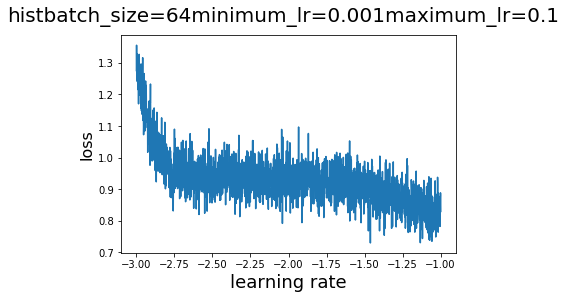

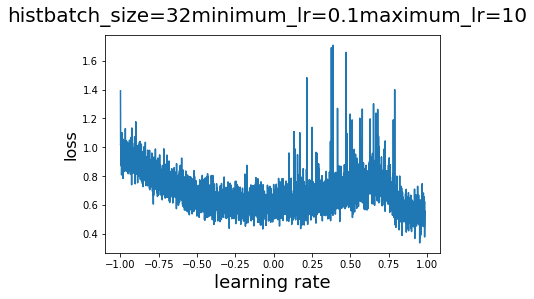

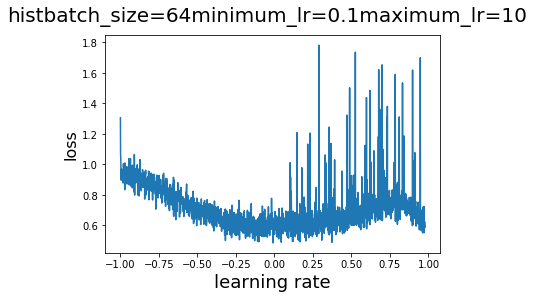

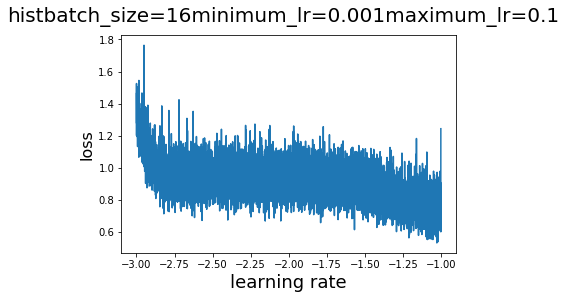

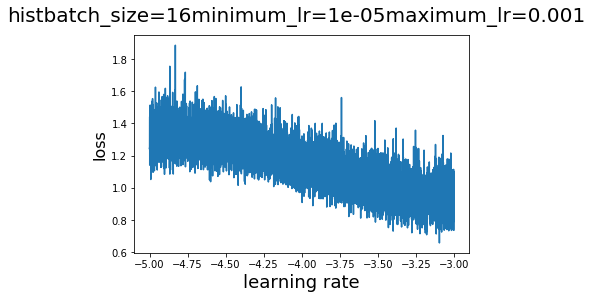

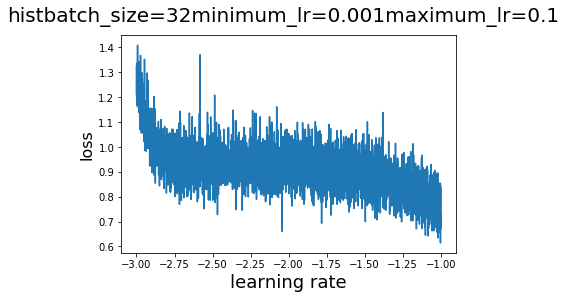

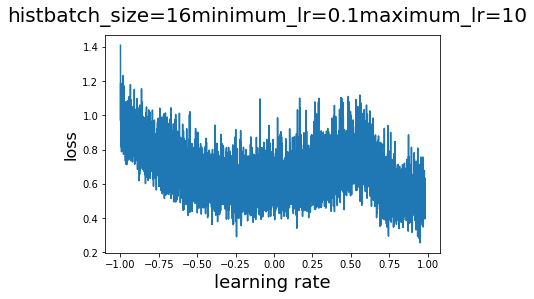

In [17]:
for his in tqdm(hists):
    save_plot(his)

In [11]:
j=(1/1000,1/10)
i=np.power(2,9)
train_stage2_collab_filt(total,
                         batch_size=i,
                         minimum_lr=j[0],maximum_lr=j[1],
                        epochs=2000)

Train on 101091 samples, validate on 2063 samples
Epoch 1/2000
101091/101091 [==============================] - 46s 451us/step - loss: 0.9746 - val_loss: 0.6153
Epoch 2/2000
101091/101091 [==============================] - 42s 413us/step - loss: 0.8780 - val_loss: 0.6384
Epoch 3/2000
101091/101091 [==============================] - 41s 410us/step - loss: 0.7890 - val_loss: 0.5839
Epoch 4/2000
101091/101091 [==============================] - 41s 409us/step - loss: 0.7157 - val_loss: 0.5642
Epoch 5/2000
101091/101091 [==============================] - 41s 409us/step - loss: 0.6881 - val_loss: 0.5586
Epoch 6/2000
101091/101091 [==============================] - 41s 409us/step - loss: 0.6805 - val_loss: 0.5585
Epoch 7/2000
100352/101091 [============================>.] - ETA: 0s - loss: 0.6687

KeyboardInterrupt: 

In [11]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)